In [ ]:
  #=======clip=======
# mkhalou le plus grand polygon
# N3AWDOU CLIPPPPPPPPPPPPP

#======cleaning=========

#MISSING VALUES --> VERIFIER RASTERS NOT SHAPEFILES AVEC MASK
# fire --> filter
# elevation --> outlier + missing values
#climate --> missing values




#===== ajout d attributs + reanalyser
# landcover --> ajouter ndvi
# elevatio  --> ajouter orientation


#Soil

## Missing values

### Raster

In [ ]:
!pip install rasterio

In [ ]:
import rasterio
import geopandas as gpd
import numpy as np
from rasterio.features import rasterize

# --- Paths ---
raster_path = "/content/drive/MyDrive/data_set/soil_type/HWSD_Algeria_Tunisia.tif"
contour_path = "/content/drive/MyDrive/data_set/kontur/contour.geojson"

# --- Load GeoJSON ---
gdf = gpd.read_file(contour_path)

with rasterio.open(raster_path) as src:
    # Reproject contour to raster CRS if needed
    if gdf.crs != src.crs:
        gdf = gdf.to_crs(src.crs)

    # Read raster as float (to allow NaN)
    band = src.read(1).astype(float)

    # Replace raster nodata with NaN
    nodata = src.nodata
    if nodata is not None:
        band[band == nodata] = np.nan

    # --- Rasterize the polygon(s) ---
    geoms = [(geom, 1) for geom in gdf.geometry]
    mask_inside = rasterize(
        geoms,
        out_shape=(src.height, src.width),
        transform=src.transform,
        fill=0,
        dtype='uint8'
    ).astype(bool)  # True = inside

# --- Count NaNs only inside the polygon ---
missing_inside_count = np.isnan(band)[mask_inside].sum()

print(f"Total missing (NaN) pixels INSIDE contour: {int(missing_inside_count)}")


Total missing (NaN) pixels INSIDE contour: 0


### missing rows

i checked that missing values for attributes are all in the same rows

In [ ]:
import pandas as pd
import numpy as np


file_path = "/content/drive/MyDrive/data_set/soil_type/soil_dataset.csv"
df_filtered = pd.read_csv(file_path)
# Columns to exclude from numeric checks
cols_to_exclude = ['geometry','DB_ID', 'FAO90','WRB4','SHARE','ID', 'USDA', 'SOTER']

# All columns except excluded ones
cols_to_check = [c for c in df_filtered.columns if c not in cols_to_exclude]

# 1️⃣ Identify invalid values
issues = {}

for col in df_filtered.columns:
    if col in ['TEXTURE_USDA', 'TEXTURE_SOTER']:
        # Count hyphens and NaNs
        mask_invalid = df_filtered[col].isin(['-', None, '']) | df_filtered[col].isna()
    elif col not in cols_to_exclude:
        # Numeric columns: negative or NaN
        mask_invalid = (df_filtered[col] < 0) | df_filtered[col].isna()
    else:
        # Skip excluded columns
        continue

    issues[col] = {
        'n_invalid': mask_invalid.sum(),
        'rows_invalid': set(df_filtered.index[mask_invalid])
    }

# 2️⃣ Print per-column summary
print("=== Invalid values summary ===")
for col, info in issues.items():
    print(f"{col:<20} -> {info['n_invalid']} invalid rows")

# 3️⃣ Check if the same rows are invalid across multiple columns
# Combine all invalid row indices
all_invalid_rows = set.union(*(v['rows_invalid'] for v in issues.values() if v['rows_invalid']))

# Create a matrix showing which columns are invalid per row
invalid_matrix = pd.DataFrame({
    col: df_filtered.index.isin(list(info['rows_invalid']))
    for col, info in issues.items()
}, index=df_filtered.index)

# Filter only rows that have at least one invalid entry
invalid_matrix = invalid_matrix.loc[invalid_matrix.any(axis=1)]

print("\n=== Rows with at least one invalid value ===")
print(invalid_matrix.sum(axis=1).value_counts().sort_index())
print("(The number above each value = how many columns were invalid in that row)")

# Optional: view rows that have multiple invalids
rows_with_multiple_issues = invalid_matrix[invalid_matrix.sum(axis=1) ==20]
print(f"\nRows with all invalid values: {len(rows_with_multiple_issues)}")
print(rows_with_multiple_issues.head())


=== Invalid values summary ===
COARSE               -> 1113 invalid rows
SAND                 -> 1113 invalid rows
SILT                 -> 1113 invalid rows
CLAY                 -> 1113 invalid rows
BULK                 -> 1113 invalid rows
REF_BULK             -> 1113 invalid rows
ORG_CARBON           -> 1113 invalid rows
PH_WATER             -> 1113 invalid rows
TOTAL_N              -> 1113 invalid rows
CN_RATIO             -> 1113 invalid rows
CEC_SOIL             -> 1113 invalid rows
CEC_CLAY             -> 1113 invalid rows
CEC_EFF              -> 1113 invalid rows
TEB                  -> 1113 invalid rows
BSAT                 -> 1113 invalid rows
ALUM_SAT             -> 1113 invalid rows
ESP                  -> 1113 invalid rows
TCARBON_EQ           -> 1113 invalid rows
GYPSUM               -> 1113 invalid rows
ELEC_COND            -> 1113 invalid rows

=== Rows with at least one invalid value ===
20    1113
Name: count, dtype: int64
(The number above each value = how many column

In [ ]:
# Unique HWSD2_SMU_IDs of rows with at least one invalid value
unique_hwsd_ids = df_filtered.loc[invalid_matrix.index, 'DB_ID']
print("rows with at least one invalid value:")
print(len(unique_hwsd_ids))




rows with at least one invalid value:
1113


np.False_

checking soil classification for those rows

DS Dunes & shifting sands

FP Fishponds

GG  Glaciers

HD  Humanly disturbed

IS small Island

RK Bare rock

ST  Salt flats

UR  Urban

WR  open  water






In [ ]:
# --- Non-soil FAO codes ---
non_soil_codes = ['DS', 'FP', 'GG', 'HD', 'IS', 'RK', 'ST', 'UR', 'WR']

# --- Filter rows by unique_hwsd_ids ---
filtered_df = df_filtered[df_filtered['DB_ID'].isin(unique_hwsd_ids)][['DB_ID','ID', 'FAO90']]


# --- Display filtered dataframe ---
print(filtered_df)

# --- Counts ---
total_rows = len(filtered_df)
in_list = filtered_df['FAO90'].isin(non_soil_codes).sum()
not_in_list = total_rows - in_list

print("\nSummary:")
print(f"Total rows: {total_rows}")
print(f"Rows with FAO90 in non-soil list: {in_list}")
print(f"Rows with FAO90 not in non-soil list: {not_in_list}")



False
       DB_ID    ID FAO90
8     291461  7001    UR
19    291461  7001    UR
22    291461  7001    UR
25    291461  7001    UR
26    291461  7001    UR
...      ...   ...   ...
5246  275380    61    RK
5248   79101  1802    DS
5250   79088    36    DS
5251   79088    36    DS
5252   79088    36    DS

[1113 rows x 3 columns]

Summary:
Total rows: 1113
Rows with FAO90 in non-soil list: 1113
Rows with FAO90 not in non-soil list: 0


**DONT BE SURPRISED RESUTS ARE DIFF FFROM REF BULK CUZ THAT ONLY SHOWS FIRST OR LAST ROW :))))**

Number of empty rows: 1113


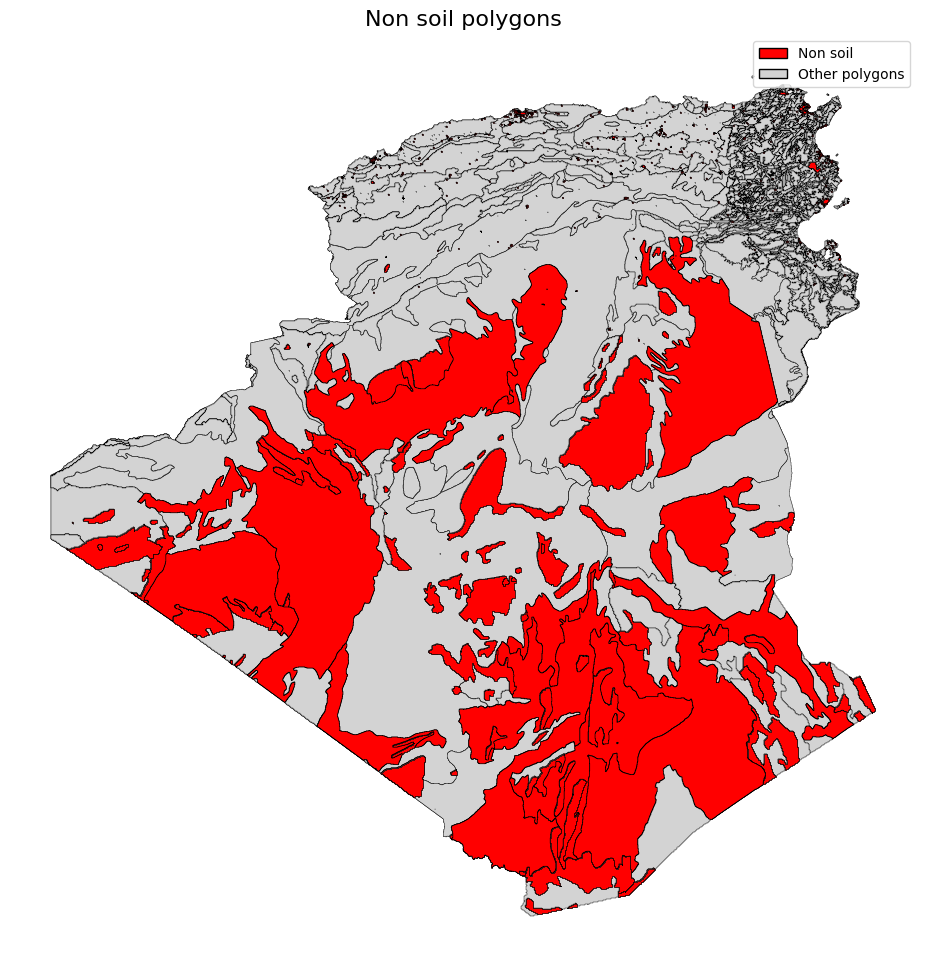

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# --- Paths ---
shapefile_path = "/content/drive/MyDrive/data_set/soil_type/shapefiles/joined attributes/HWSD_Algeria_Tunisia_joined.shp"

# --- Load shapefile ---
gdf = gpd.read_file(shapefile_path)

# Make sure both are the same type


# Subset
df_kept = filtered_df
ids_to_plot =df_kept['DB_ID'].unique()
subset_gdf = gdf[gdf['DB_ID'].isin(ids_to_plot)]

print(f"Number of empty rows: {len(df_kept)}")

# --- Plot all polygons (grey) and subset (red) ---
fig, ax = plt.subplots(figsize=(12, 12))
gdf.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.3)
subset_gdf.plot(ax=ax, color='red', edgecolor='black', linewidth=0.5)

# --- Add title and legend ---
ax.set_title("Non soil polygons", fontsize=16)
ax.axis('off')

legend_elements = [
    Patch(facecolor='red', edgecolor='black', label='Non soil'),
    Patch(facecolor='lightgrey', edgecolor='black', label='Other polygons')
]
ax.legend(handles=legend_elements)

plt.show()




#### handling the rest



On ne peut pas entraîner un modèle de ML pour remplir les valeurs manquantes si toute la ligne est vide et qu’il n’y a pas seulement un seul attribut manquant par ligne. C’est pour cela que nous avons bien étudié la documentation pour comprendre pourquoi certaines données de sol sont volontairement manquantes et pourquoi elles n’ont pas été renseignées, non seulement pour l’Algérie, mais pour tous les déserts du monde.
C’est vrai que ces zones peuvent être peu nombreuses, mais le Sahara algérien couvre une grande surface de l’Algérie, donc après fusion (merge), cela représente un volume de données important.

+ la plupart de ces zones sont considérées comme "non-soil", **d'ou on ne peut pas leur affecter des valeurs en utilisant ni  l imputation ni en entrainant un modele.**

In [ ]:
# Display number of null values per column
null_counts = df_filtered.isnull().sum()
print("Number of null values per column:")
print(null_counts[null_counts > 0])  # only show columns that have nulls


Number of null values per column:
USDA        1113
REF_BULK    1113
dtype: int64


#### remlacer USDA et REF_BULK

In [ ]:
# Replace empty/NaN values in USDA with '-'
df_filtered['USDA'] = df_filtered['USDA'].fillna('-')

# Replace empty/NaN values in REF_BULK with the corresponding BULK value
df_filtered['REF_BULK'] = df_filtered['REF_BULK'].fillna(df_filtered['BULK'])


In [ ]:
# Display number of null values per column
null_counts = df_filtered.isnull().sum()
print("Number of null values per column:")
print(null_counts[null_counts > 0])  # only show columns that have nulls

Number of null values per column:
Series([], dtype: int64)


In [ ]:
# --- Path to save ---
output_path = "/content/drive/MyDrive/data_set/soil_type/shapefiles/clean/filtered_df_cleaned.csv"

# --- Save to CSV ---
df_filtered.to_csv(output_path, index=False)

print(f"Cleaned filtered_df saved to: {output_path}")


Cleaned filtered_df saved to: /content/drive/MyDrive/data_set/soil_type/shapefiles/clean/filtered_df_cleaned.csv


In [ ]:
!pip install fiona

In [ ]:
import rasterio
from rasterio.features import shapes
import fiona
from fiona.crs import from_epsg
import numpy as np
from shapely.geometry import shape, mapping
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:

raster_path = "/content/drive/MyDrive/data_set/soil_type/HWSD_Algeria_Tunisia.tif"
shapefile_path = "/content/drive/MyDrive/data_set/soil_type/shapefiles/clean/cleaned_soil.shp"

with rasterio.open(raster_path) as src:
    raster_data = src.read(1)
    transform = src.transform
    crs = src.crs

    # Mask to ignore no-data values
    mask = raster_data != src.nodata

    # Generate shapes for all contiguous regions (do NOT merge by value)
    shapes_gen = shapes(raster_data, mask=mask, transform=transform)

    # Define schema for shapefile
    schema = {
        'geometry': 'Polygon',
        'properties': {'id': 'int'}
    }

    # Write shapefile
    with fiona.open(shapefile_path, 'w', driver='ESRI Shapefile', crs=crs, schema=schema) as shp:
        for geom, value in shapes_gen:
            shp.write({
                'geometry': geom,
                'properties': {'id': int(value)}
            })


In [ ]:
import fiona
from collections import Counter

shapefile_path =  "/content/drive/MyDrive/data_set/soil_type/shapefiles/clean/cleaned_soil.shp"

# Read shapefile and extract polygon IDs
with fiona.open(shapefile_path, 'r') as shp:
    polygon_ids = [int(feature['properties']['id']) for feature in shp]

# Total number of polygons
total_polygons = len(polygon_ids)
print("Total number of polygons:", total_polygons)

id_counts = Counter(polygon_ids)
# Total unique IDs
print("\nTotal unique raster IDs:", len(id_counts))

Total number of polygons: 3104

Total unique raster IDs: 389


In [ ]:
import pandas as pd
import geopandas as gpd
from shapely import wkt

# --- Paths ---
csv_path = "/content/drive/MyDrive/data_set/soil_type/shapefiles/clean/filtered_df_cleaned.csv"
output_path = "/content/drive/MyDrive/data_set/soil_type/shapefiles/clean/cleaned_soil.shp"

# --- Read CSV ---
df = pd.read_csv(csv_path)

# --- Convert geometry column from WKT to shapely objects if needed ---
df['geometry'] = df['geometry'].apply(wkt.loads)

# --- Rename columns for shapefile compatibility ---
df = df.rename(columns={
    'HWSD2_SMU_ID': 'ID',
    'TEXTURE_USDA': 'USDA',
    'TEXTURE_SOTER': 'SOTER'
})

# --- Convert to GeoDataFrame ---
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")  # set your CRS if different

# --- Save to shapefile ---
gdf.to_file(output_path)

# --- Load and check ---
clean_gdf = gpd.read_file(output_path)
print(f"Shapefile saved at: {output_path}")
print(f"Number of polygons in cleaned shapefile: {len(clean_gdf)}")


Shapefile saved at: /content/drive/MyDrive/data_set/soil_type/shapefiles/clean/cleaned_soil.shp
Number of polygons in cleaned shapefile: 5254


In [ ]:
# import rasterio
# from rasterio.features import shapes
# import geopandas as gpd
# import pandas as pd
# from shapely.geometry import shape

# # --- Paths ---
# raster_path = "/content/drive/MyDrive/data_set/soil_type/HWSD_Algeria_Tunisia.tif"
# csv_path = "/content/drive/MyDrive/data_set/soil_type/shapefiles/clean/filtered_df_cleaned.csv"
# output_path = "/content/drive/MyDrive/data_set/soil_type/shapefiles/clean/cleaned_soil.shp"

# # --- Load raster ---
# with rasterio.open(raster_path) as src:
#     raster = src.read(1)  # read first band
#     transform = src.transform
#     crs = src.crs

# # --- Create polygons for each raster cell with a value ---
# mask = raster != src.nodata  # only valid data
# shapes_gen = shapes(raster, mask=mask, transform=transform)

# # --- Convert to GeoDataFrame ---
# polygons = []
# values = []
# for geom, value in shapes_gen:
#     polygons.append(shape(geom))
#     values.append(value)

# raster_gdf = gpd.GeoDataFrame({'ID': values, 'geometry': polygons}, crs=crs)

# # --- Load CSV with additional attributes ---
# df_csv = pd.read_csv(csv_path)

# # --- Join CSV attributes to raster polygons using 'ID' ---
# merged_gdf = raster_gdf.merge(df_csv, on='ID', how='left')

# # --- Save to shapefile ---
# merged_gdf.to_file(output_path)

# print(f"Shapefile saved at: {output_path}")
# print(f"Number of polygons: {len(merged_gdf)}")


      ID  DB_ID FAO90  WRB4  SHARE  COARSE  SAND  SILT  CLAY  USDA  ...  \
0  31805  24745   ARh    AR     40       9    87     9     4  12.0  ...   
1  31805  77553   CMx  CMcr     60       5    33    31    36   5.0  ...   
2  31805  24745   ARh    AR     40       9    87     9     4  12.0  ...   
3  31805  77553   CMx  CMcr     60       5    33    31    36   5.0  ...   
4  31802  12266   ALh  ALha     70      11    40    41    19   9.0  ...   

  CEC_CLAY  CEC_EFF  TEB  BSAT  ALUM_SAT  ESP  TCARBON_EQ  GYPSUM  ELEC_COND  \
0       33        3    3    76         6    2         0.0     0.1          0   
1       34       15   17    82         0    1         0.0     1.6          1   
2       33        3    3    76         6    2         0.0     0.1          0   
3       34       15   17    82         0    1         0.0     1.6          1   
4       26        6    5    47        21    1         0.0     0.1          0   

                                            geometry  
0  POLYGON ((

<Figure size 1200x1200 with 0 Axes>

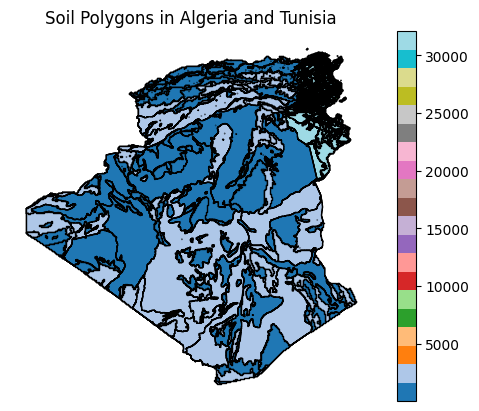

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

shapefile_path ="/content/drive/MyDrive/data_set/soil_type/shapefiles/clean/cleaned_soil.shp"

# Load shapefile with GeoPandas
gdf = gpd.read_file(shapefile_path)

# Quick look at the data
print(gdf.head())

# Plot the polygons colored by their ID
plt.figure(figsize=(12, 12))
gdf.plot(column='ID', cmap='tab20', legend=True, edgecolor='black')
plt.title("Soil Polygons in Algeria and Tunisia")
plt.axis('off')
plt.show()


## Outliers (negative values ignored)


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import ceil
from matplotlib.patches import Patch

# --- Load shapefile ---
shapefile_path = "/content/drive/MyDrive/data_set/soil_type/shapefiles/joined attributes/HWSD_Algeria_Tunisia_joined.shp"
gdf = gpd.read_file(shapefile_path)

# --- Columns to exclude ---
cols_to_exclude = ['  SOTER', 'USDA', 'ID', 'geometry']

# --- Select all other columns ---
cols_to_plot = [c for c in gdf.columns if c not in cols_to_exclude]

# --- Function: classify outliers ---
def classify_outliers(series):
    series = pd.to_numeric(series, errors='coerce')
    if series.notna().sum() == 0:
        return np.full(len(series), 'lightgrey', dtype=object), False

    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    small_outliers = (series < lower) & (series >= 0)
    big_outliers = series > upper

    color = np.full(len(series), 'lightgrey', dtype=object)
    color[small_outliers] = 'orange'
    color[big_outliers] = 'red'

    has_outliers = small_outliers.any() or big_outliers.any()
    return color, has_outliers

# --- Determine which columns have outliers ---
cols_with_outliers = []
color_maps = {}
for col in cols_to_plot:
    colors, has_outliers = classify_outliers(gdf[col])
    if has_outliers:
        cols_with_outliers.append(col)
        color_maps[col] = colors

print(f"\nColumns with outliers ({len(cols_with_outliers)}):", cols_with_outliers)

# --- Plot setup ---
n_cols = 2
n_rows = ceil(len(cols_with_outliers) / n_cols)

# Make figure taller and maps take much more space (1:5 ratio)
fig = plt.figure(figsize=(16, 10 * n_rows))
gs = fig.add_gridspec(n_rows * 2, n_cols, height_ratios=[1, 5] * n_rows)

# --- Plot each variable ---
for i, col in enumerate(cols_with_outliers):
    row = i // n_cols
    col_pos = i % n_cols

    # Small top boxplot
    ax_box = fig.add_subplot(gs[row * 2, col_pos])
    data = pd.to_numeric(gdf[col], errors='coerce').dropna()
    ax_box.boxplot(data, vert=False, patch_artist=True,
                   boxprops=dict(facecolor='lightblue', color='black'),
                   medianprops=dict(color='red'))
    ax_box.set_title(f"{col} Distribution", fontsize=11)
    ax_box.set_yticks([])
    ax_box.tick_params(axis='x', labelsize=9)
    ax_box.grid(True, axis='x', linestyle='--', alpha=0.5)

    # Larger bottom map
    ax_map = fig.add_subplot(gs[row * 2 + 1, col_pos])
    gdf.plot(ax=ax_map, color=color_maps[col], edgecolor='black', linewidth=0.1)
    ax_map.set_title(f"{col} Outliers", fontsize=11)
    ax_map.axis('off')

# Remove unused cells (in case odd number of columns)
for j in range(len(cols_with_outliers), n_rows * n_cols):
    fig.delaxes(fig.add_subplot(gs[(j // n_cols) * 2 + 1, j % n_cols]))

# --- Legend ---
legend_elements = [
    Patch(facecolor='lightgrey', edgecolor='black', label='Normal'),
    Patch(facecolor='orange', edgecolor='black', label='Small outlier (≥0)'),
    Patch(facecolor='red', edgecolor='black', label='Big outlier')
]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=12)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
### COARSE

In [ ]:
import geopandas as gpd
import pandas as pd

# --- Load shapefile ---
shapefile_path = "/content/drive/MyDrive/data_set/soil_type/shapefiles/joined attributes/HWSD_Algeria_Tunisia_joined.shp"
gdf = gpd.read_file(shapefile_path)

# --- Ensure numeric ---
for col in ['COARSE', 'SAND', 'SILT', 'CLAY']:
    gdf[col] = pd.to_numeric(gdf[col], errors='coerce')

# --- Compute upper outlier threshold for COARSE ---
q1 = gdf['COARSE'].quantile(0.25)
q3 = gdf['COARSE'].quantile(0.75)
iqr = q3 - q1
upper = q3 + 1.5 * iqr

# --- Mask for high COARSE outliers > 0 ---
high_outliers_mask = (gdf['COARSE'] > upper) & (gdf['COARSE'] > 0)

# --- Filter high outliers ---
high_outliers = gdf[high_outliers_mask]

# --- Print key information ---
print("Number of high COARSE outliers (>0):", len(high_outliers))
print(high_outliers[['ID','COARSE', 'SAND', 'SILT', 'CLAY']].head(20))  # show first 20


Number of high COARSE outliers (>0): 140
         ID  COARSE  SAND  SILT  CLAY
821   31881      46    47    29    24
836   31893      46    47    29    24
918   31869      46    47    29    24
931   31881      46    47    29    24
998   31893      46    47    29    24
1001  31871      46    47    29    24
1004  31894      46    47    29    24
1016  31869      46    47    29    24
1027  31870      46    47    29    24
1042  31867      46    47    29    24
1091  31869      46    47    29    24
1100  31837      46    47    29    24
1121  31867      46    47    29    24
1139  31839      46    47    29    24
1145  31867      46    47    29    24
1149  31867      46    47    29    24
1158  31839      46    47    29    24
1160  31856      46    47    29    24
1173  31856      46    47    29    24
1186  31856      46    47    29    24


### BSAT

In [ ]:
import geopandas as gpd
import pandas as pd

# --- Load shapefile ---
shapefile_path = "/content/drive/MyDrive/data_set/soil_type/shapefiles/joined attributes/HWSD_Algeria_Tunisia_joined.shp"
gdf = gpd.read_file(shapefile_path)

# --- Ensure numeric ---
gdf['BSAT'] = pd.to_numeric(gdf['BSAT'], errors='coerce')
gdf['PH_WATER'] = pd.to_numeric(gdf['PH_WATER'], errors='coerce')

# --- Compute lower outlier threshold for BSAT ---
q1 = gdf['BSAT'].quantile(0.25)
q3 = gdf['BSAT'].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr

# --- Mask for low BSAT outliers > 0 ---
low_outliers_mask = (gdf['BSAT'] < lower) & (gdf['BSAT'] > 0)

# --- Filter low outliers ---
low_outliers = gdf[low_outliers_mask]

# --- Print key information ---
print("Number of low BSAT outliers (>0):", len(low_outliers))
print(low_outliers[['BSAT', 'PH_WATER']].head(20))  # show first 20


Number of low BSAT outliers (>0): 16
     BSAT  PH_WATER
41     29       5.1
224    29       5.1
244    18       4.7
245    10       4.3
296    18       4.7
297    10       4.3
408    10       4.3
436    10       4.3
473    10       4.3
500    10       4.3
520    10       4.3
541    18       4.7
542    10       4.3
558    10       4.3
935    10       4.3
983    10       4.3


### ALUM SAT

In [ ]:
import geopandas as gpd
import pandas as pd

# --- Load shapefile ---
shapefile_path = "/content/drive/MyDrive/data_set/soil_type/shapefiles/joined attributes/HWSD_Algeria_Tunisia_joined.shp"
gdf = gpd.read_file(shapefile_path)

# --- Ensure numeric ---
gdf['ALUM_SAT'] = pd.to_numeric(gdf['ALUM_SAT'], errors='coerce')
gdf['PH_WATER'] = pd.to_numeric(gdf['PH_WATER'], errors='coerce')

# --- Compute lower outlier threshold for ALUM_SAT ---
q1 = gdf['ALUM_SAT'].quantile(0.25)
q3 = gdf['ALUM_SAT'].quantile(0.75)
iqr = q3 - q1
upper = q1 + 1.5 * iqr

# --- Mask for low ALUM_SAT outliers > 0 ---
low_outliers_mask = (gdf['ALUM_SAT'] > upper)

# --- Filter low outliers ---
low_outliers = gdf[low_outliers_mask]

# --- Print key information ---
print("Number of low ALUM_SAT outliers (>0):", len(low_outliers))
print(low_outliers[['ALUM_SAT', 'PH_WATER']].head(20))  # show first 20


Number of low ALUM_SAT outliers (>0): 101
    ALUM_SAT  PH_WATER
0          6       5.7
2          6       5.7
4         21       5.3
5         26       5.8
6          6       5.7
9          6       5.7
10        25       5.8
11         6       5.7
12        25       5.8
13         6       5.7
14        25       5.8
15         6       5.7
17         6       5.7
23         6       5.7
28         6       5.7
29        25       5.8
30         6       5.7
33        26       5.8
34        11       5.6
37         6       5.7


### ESP

In [ ]:
import geopandas as gpd
import pandas as pd

# --- Load shapefile ---
shapefile_path = "/content/drive/MyDrive/data_set/soil_type/shapefiles/joined attributes/HWSD_Algeria_Tunisia_joined.shp"
gdf = gpd.read_file(shapefile_path)

# --- Ensure numeric ---
gdf['ESP'] = pd.to_numeric(gdf['ESP'], errors='coerce')
gdf['PH_WATER'] = pd.to_numeric(gdf['PH_WATER'], errors='coerce')

# --- Compute upper outlier threshold for ESP ---
q1 = gdf['ESP'].quantile(0.25)
q3 = gdf['ESP'].quantile(0.75)
iqr = q3 - q1
upper = q3 + 1.5 * iqr

# --- Mask for high ESP outliers > 0 ---
high_esp_mask = (gdf['ESP'] > upper) & (gdf['ESP'] > 0)

# --- Filter high ESP outliers ---
high_esp_outliers = gdf[high_esp_mask]

# --- Print key information ---
print("Number of high ESP outliers (>0):", len(high_esp_outliers))
print(high_esp_outliers[['ESP', 'PH_WATER']].head(20))  # show first 20


Number of high ESP outliers (>0): 521
     ESP  PH_WATER
21    63       7.5
113   63       7.5
116   41       7.8
192   67       8.5
193   56       8.6
205   41       7.8
214   67       8.5
215   56       8.6
219   67       8.5
220   56       8.6
221   63       7.5
222   67       8.5
223   56       8.6
246   67       8.5
247   56       8.6
337   63       7.5
356   63       7.5
397   63       7.5
412   63       7.5
418   38       8.1


In [ ]:
###TCARBON_EQ

In [ ]:
import geopandas as gpd
import pandas as pd

# --- Load shapefile ---
shapefile_path = "/content/drive/MyDrive/data_set/soil_type/shapefiles/joined attributes/HWSD_Algeria_Tunisia_joined.shp"
gdf = gpd.read_file(shapefile_path)

# --- Ensure numeric ---
gdf['TCARBON_EQ'] = pd.to_numeric(gdf['TCARBON_EQ'], errors='coerce')
gdf['PH_WATER'] = pd.to_numeric(gdf['PH_WATER'], errors='coerce')

# --- Compute upper outlier threshold for TCARBON_EQ ---
q1 = gdf['TCARBON_EQ'].quantile(0.25)
q3 = gdf['TCARBON_EQ'].quantile(0.75)
iqr = q3 - q1
upper = q3 + 1.5 * iqr

# --- Mask for high TCARBON_EQ outliers > 0 ---
high_tcarbon_mask = (gdf['TCARBON_EQ'] > upper) & (gdf['TCARBON_EQ'] > 0)

# --- Filter high TCARBON_EQ outliers ---
high_tcarbon_outliers = gdf[high_tcarbon_mask]

# --- Print key information ---
print("Number of high TCARBON_EQ outliers (>0):", len(high_tcarbon_outliers))
print(high_tcarbon_outliers[['TCARBON_EQ']].head(20))  # show first 20


Number of high TCARBON_EQ outliers (>0): 2
     TCARBON_EQ
116   31.299999
205   31.299999


#Elevation


In [ ]:
!pip install rasterio

### Elevation

##Missing values (non missing values)

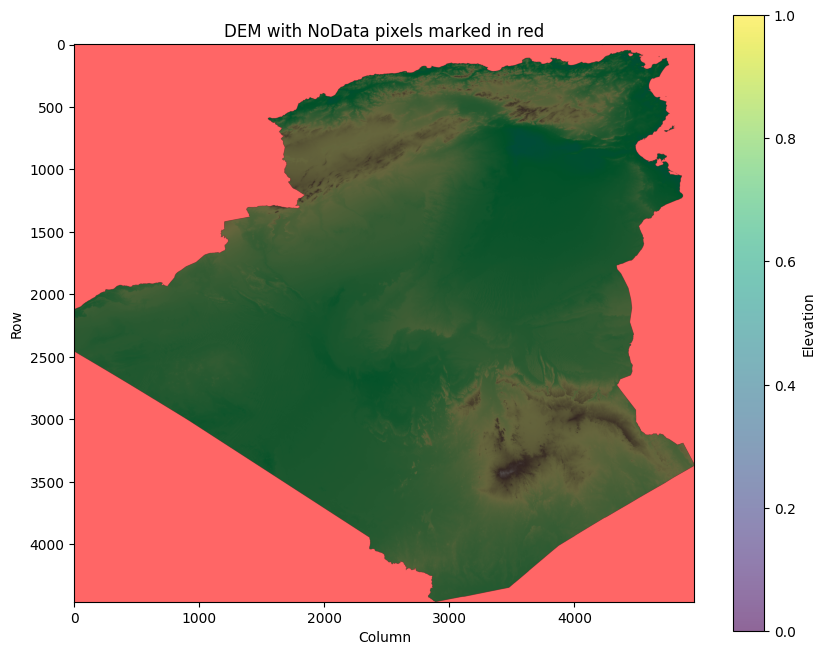

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# --- Path to raster ---
raster_path = "/content/drive/MyDrive/data_set/Elevation/clipped_algeria_tunisia.tif"

# --- Open raster ---
with rasterio.open(raster_path) as src:
    band = src.read(1).astype(float)  # read first band as float
    nodata = src.nodata
    # Replace raster nodata with np.nan
    if nodata is not None:
        band[band == nodata] = np.nan

# --- Plot DEM ---
plt.figure(figsize=(10,8))
plt.imshow(band, cmap='terrain')  # base DEM

# --- Overlay NaNs in solid red ---
nan_mask = np.isnan(band)
plt.imshow(np.dstack([nan_mask, np.zeros_like(band), np.zeros_like(band)]), alpha=0.6)

plt.colorbar(label='Elevation')
plt.title("DEM with NoData pixels marked in red")
plt.xlabel("Column")
plt.ylabel("Row")
plt.show()


In [ ]:
import rasterio
import geopandas as gpd
import numpy as np
from rasterio.features import rasterize

# --- Paths ---
raster_path = "/content/drive/MyDrive/data_set/Elevation/clipped_algeria_tunisia.tif"
contour_path = "/content/drive/MyDrive/data_set/kontur/contour.geojson"

# --- Load GeoJSON ---
gdf = gpd.read_file(contour_path)

with rasterio.open(raster_path) as src:
    # Reproject contour to raster CRS if needed
    if gdf.crs != src.crs:
        gdf = gdf.to_crs(src.crs)

    # Read raster as float (to allow NaN)
    band = src.read(1).astype(float)

    # Replace raster nodata with NaN
    nodata = src.nodata
    if nodata is not None:
        band[band == nodata] = np.nan

    # --- Rasterize the polygon(s) ---
    geoms = [(geom, 1) for geom in gdf.geometry]
    mask_inside = rasterize(
        geoms,
        out_shape=(src.height, src.width),
        transform=src.transform,
        fill=0,
        dtype='uint8'
    ).astype(bool)  # True = inside

# --- Count NaNs only inside the polygon ---
missing_inside_count = np.isnan(band)[mask_inside].sum()

print(f"Total missing (NaN) pixels INSIDE contour: {int(missing_inside_count)}")


Total missing (NaN) pixels INSIDE contour: 0


### Aspect

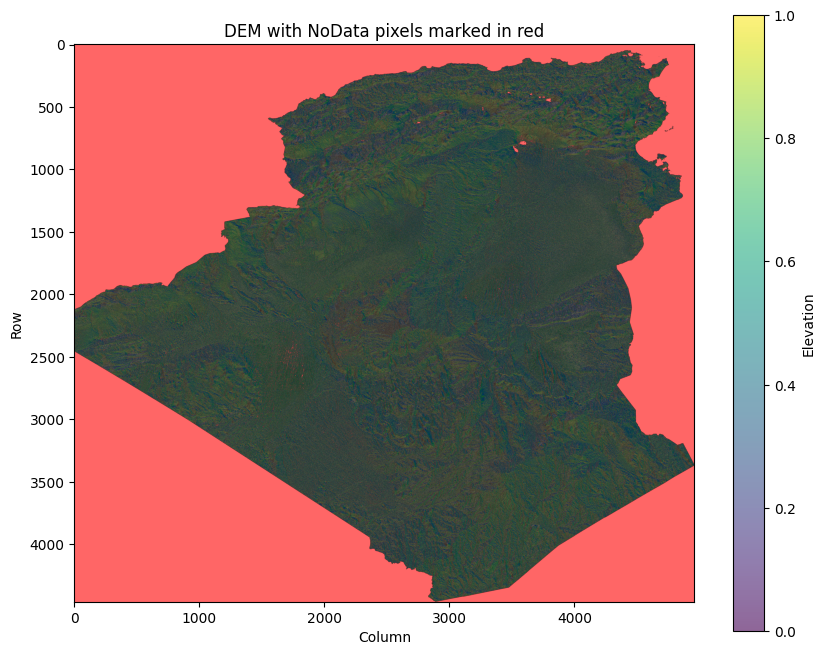

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# --- Path to raster ---
raster_path = "/content/drive/MyDrive/data_set/Elevation/Aspect.tif"

# --- Open raster ---
with rasterio.open(raster_path) as src:
    band = src.read(1).astype(float)  # read first band as float
    nodata = src.nodata
    # Replace raster nodata with np.nan
    if nodata is not None:
        band[band == nodata] = np.nan

# --- Plot DEM ---
plt.figure(figsize=(10,8))
plt.imshow(band, cmap='terrain')  # base DEM

# --- Overlay NaNs in solid red ---
nan_mask = np.isnan(band)
plt.imshow(np.dstack([nan_mask, np.zeros_like(band), np.zeros_like(band)]), alpha=0.6)

plt.colorbar(label='Elevation')
plt.title("DEM with NoData pixels marked in red")
plt.xlabel("Column")
plt.ylabel("Row")
plt.show()


In [ ]:
import rasterio
import geopandas as gpd
import numpy as np
from rasterio.features import rasterize

# --- Paths ---
raster_path = "/content/drive/MyDrive/data_set/Elevation/Aspect.tif"
contour_path = "/content/drive/MyDrive/data_set/kontur/contour.geojson"

# --- Load GeoJSON ---
gdf = gpd.read_file(contour_path)

with rasterio.open(raster_path) as src:
    # Reproject contour to raster CRS if needed
    if gdf.crs != src.crs:
        gdf = gdf.to_crs(src.crs)

    # Read raster as float (to allow NaN)
    band = src.read(1).astype(float)

    # Replace raster nodata with NaN
    nodata = src.nodata
    if nodata is not None:
        band[band == nodata] = np.nan

    # --- Rasterize the polygon(s) ---
    geoms = [(geom, 1) for geom in gdf.geometry]
    mask_inside = rasterize(
        geoms,
        out_shape=(src.height, src.width),
        transform=src.transform,
        fill=0,
        dtype='uint8'
    ).astype(bool)  # True = inside

# --- Count NaNs only inside the polygon ---
missing_inside_count = np.isnan(band)[mask_inside].sum()

print(f"Total missing (NaN) pixels INSIDE contour: {int(missing_inside_count)}")


Total missing (NaN) pixels INSIDE contour: 103285


In [ ]:
import rasterio
import geopandas as gpd
import numpy as np
from rasterio.features import rasterize

# --- Paths ---
raster_path = "/content/drive/MyDrive/data_set/Elevation/Aspect.tif"
contour_path = "/content/drive/MyDrive/data_set/kontur/contour.geojson"
output_path = "/content/drive/MyDrive/data_set/Elevation/cleaned/cleaned_aspect.tif"

# --- Load GeoJSON ---
gdf = gpd.read_file(contour_path)

with rasterio.open(raster_path) as src:
    profile = src.profile.copy()  # keep original metadata

    # Reproject contour to raster CRS if needed
    if gdf.crs != src.crs:
        gdf = gdf.to_crs(src.crs)

    # Read raster as float
    band = src.read(1).astype(float)

    # Replace raster nodata with NaN for processing
    nodata = src.nodata
    if nodata is not None:
        band[band == nodata] = np.nan

    # Rasterize the polygon
    geoms = [(geom, 1) for geom in gdf.geometry]
    mask_inside = rasterize(
        geoms,
        out_shape=(src.height, src.width),
        transform=src.transform,
        fill=0,
        dtype='uint8',
        all_touched=True
    ).astype(bool)

    # --- Replace NaNs inside the polygon with -1 ---
    band[np.isnan(band) & mask_inside] = -1

    # Do NOT change profile['nodata']
    # Save the cleaned raster
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(band.astype(rasterio.float32), 1)

print(f"Saved raster with NaNs inside contour replaced by -1 at: {output_path}")


Saved raster with NaNs inside contour replaced by -1 at: /content/drive/MyDrive/data_set/Elevation/cleaned/cleaned_aspect.tif


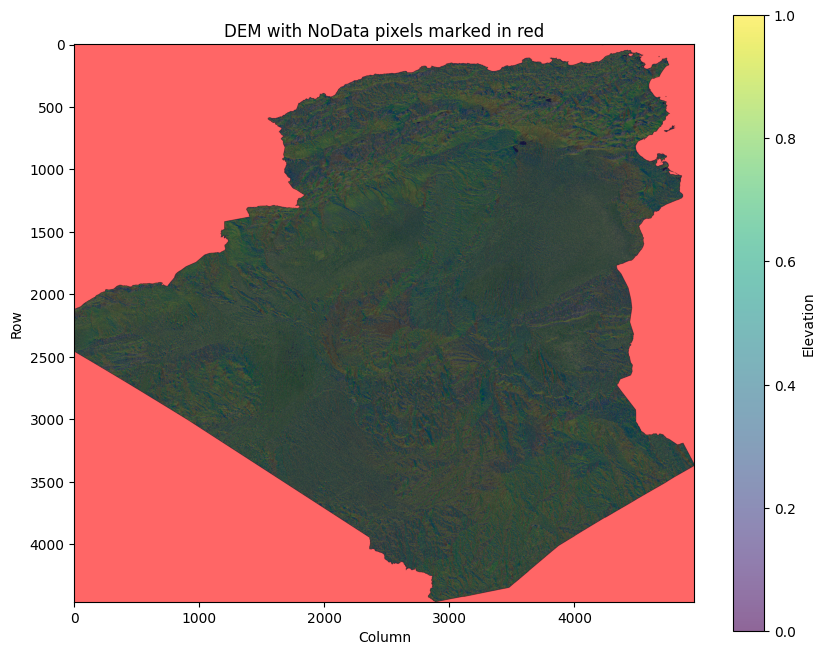

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# --- Path to raster ---
raster_path = "/content/drive/MyDrive/data_set/Elevation/cleaned/cleaned_aspect.tif"

# --- Open raster ---
with rasterio.open(raster_path) as src:
    band = src.read(1).astype(float)  # read first band as float
    nodata = src.nodata
    # Replace raster nodata with np.nan
    if nodata is not None:
        band[band == nodata] = np.nan

# --- Plot DEM ---
plt.figure(figsize=(10,8))
plt.imshow(band, cmap='terrain')  # base DEM

# --- Overlay NaNs in solid red ---
nan_mask = np.isnan(band)
plt.imshow(np.dstack([nan_mask, np.zeros_like(band), np.zeros_like(band)]), alpha=0.6)

plt.colorbar(label='Elevation')
plt.title("DEM with NoData pixels marked in red")
plt.xlabel("Column")
plt.ylabel("Row")
plt.show()


In [ ]:
import rasterio
import geopandas as gpd
import numpy as np
from rasterio.features import rasterize

# --- Paths ---
raster_path = "/content/drive/MyDrive/data_set/Elevation/cleaned/cleaned_aspect.tif"
contour_path = "/content/drive/MyDrive/data_set/kontur/contour.geojson"

# --- Load GeoJSON ---
gdf = gpd.read_file(contour_path)

with rasterio.open(raster_path) as src:
    # Reproject contour to raster CRS if needed
    if gdf.crs != src.crs:
        gdf = gdf.to_crs(src.crs)

    # Read raster as float (to allow NaN)
    band = src.read(1).astype(float)

    # Replace raster nodata with NaN
    nodata = src.nodata
    if nodata is not None:
        band[band == nodata] = np.nan

    # --- Rasterize the polygon(s) ---
    geoms = [(geom, 1) for geom in gdf.geometry]
    mask_inside = rasterize(
        geoms,
        out_shape=(src.height, src.width),
        transform=src.transform,
        fill=0,
        dtype='uint8'
    ).astype(bool)  # True = inside

# --- Count NaNs only inside the polygon ---
missing_inside_count = np.isnan(band)[mask_inside].sum()

print(f"Total missing (NaN) pixels INSIDE contour: {int(missing_inside_count)}")


Total missing (NaN) pixels INSIDE contour: 0


##Outliers

Smallest valid pixel value: -872.0
Pixel 0: lon=7.995694444444297, lat=29.47486111111104


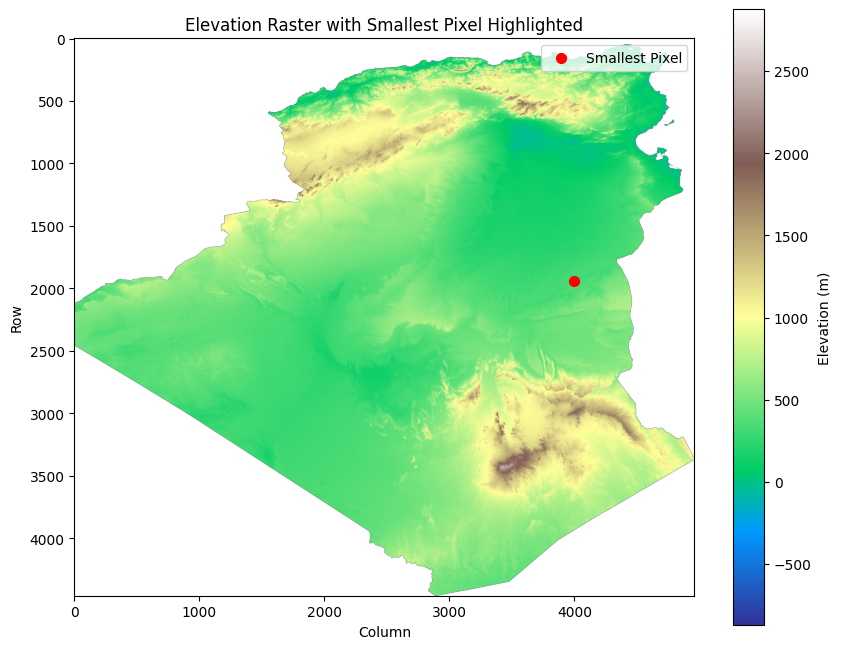

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Path to raster
raster_path = "/content/drive/MyDrive/data_set/Elevation/clipped_algeria_tunisia.tif"

# Open raster
with rasterio.open(raster_path) as src:
    raster_data = src.read(1)
    nodata_value = src.nodata
    transform = src.transform  # for coordinates

# Convert to float
raster_data = raster_data.astype(float)

# Mask NoData values
if nodata_value is not None:
    raster_data[raster_data == nodata_value] = np.nan

# Find smallest valid pixel
min_value = np.nanmin(raster_data)
print("Smallest valid pixel value:", min_value)

# Find its row and column
min_row, min_col = np.where(raster_data == min_value)

# Convert to geographic coordinates (lon, lat)
coords = [transform * (c, r) for r, c in zip(min_row, min_col)]
for i, (x, y) in enumerate(coords):
    print(f"Pixel {i}: lon={x}, lat={y}")

# Plot raster and mark the smallest pixel
plt.figure(figsize=(10,8))
plt.imshow(raster_data, cmap='terrain')
plt.colorbar(label='Elevation (m)')
plt.title("Elevation Raster with Smallest Pixel Highlighted")
plt.xlabel("Column")
plt.ylabel("Row")

# Mark the smallest pixel(s) on the map
plt.scatter(min_col, min_row, color='red', s=50, label='Smallest Pixel')
plt.legend()
plt.show()


Upper threshold for outliers: 1277.0
Lower threshold for outliers: -267.0


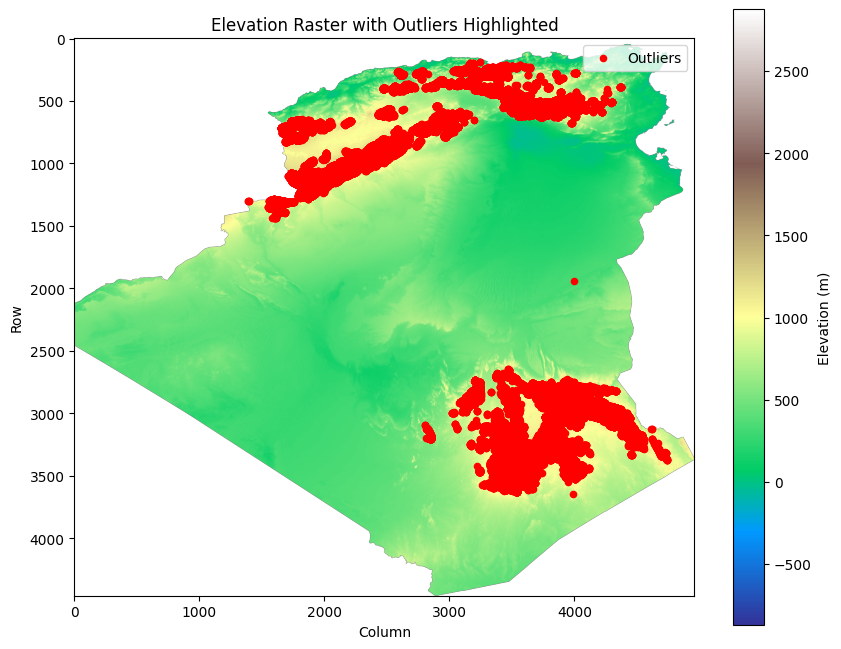

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Load raster
raster_path = "/content/drive/MyDrive/data_set/Elevation/clipped_algeria_tunisia.tif"
with rasterio.open(raster_path) as src:
    raster_data = src.read(1).astype(float)
    nodata_value = src.nodata
    transform = src.transform

# Mask NoData
if nodata_value is not None:
    raster_data[raster_data == nodata_value] = np.nan

# Flatten valid pixels
valid_pixels = raster_data[~np.isnan(raster_data)]

# Compute Q1, Q3 and IQR
q1 = np.percentile(valid_pixels, 25)
q3 = np.percentile(valid_pixels, 75)
iqr = q3 - q1

# Define outliers (above Q3 + 1.5*IQR or below Q1 - 1.5*IQR)
upper_thresh = q3 + 1.5*iqr
lower_thresh = q1 - 1.5*iqr

print("Upper threshold for outliers:", upper_thresh)
print("Lower threshold for outliers:", lower_thresh)

# Find outlier pixels
outlier_rows, outlier_cols = np.where((raster_data > upper_thresh) | (raster_data < lower_thresh))
plt.figure(figsize=(10,8))
plt.imshow(raster_data, cmap='terrain')
plt.colorbar(label='Elevation (m)')
plt.title("Elevation Raster with Outliers Highlighted")
plt.xlabel("Column")
plt.ylabel("Row")

# Mark outliers
plt.scatter(outlier_cols, outlier_rows, color='red', s=20, label='Outliers')
plt.legend()
plt.show()

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import generic_filter

# --- Paths ---
raster_path = "/content/drive/MyDrive/data_set/Elevation/clipped_algeria_tunisia.tif"
output_path = "/content/drive/MyDrive/data_set/Elevation/cleaned/cleaned_elevation.tif"

# --- Open raster ---
with rasterio.open(raster_path) as src:
    raster_data = src.read(1).astype(float)
    profile = src.profile.copy()
    nodata_value = src.nodata
    transform = src.transform

# --- Mask NoData ---
if nodata_value is not None:
    raster_data[raster_data == nodata_value] = np.nan

# --- Find the smallest valid pixel ---
min_value = np.nanmin(raster_data)
min_row, min_col = np.where(raster_data == min_value)

print("Original smallest value:", min_value)

# --- Replace each smallest pixel with mean of its valid neighbors ---
def mean_neighbors(values):
    center = values[4]  # 3x3 flattened
    neighbors = np.delete(values, 4)
    valid_neighbors = neighbors[~np.isnan(neighbors)]
    if len(valid_neighbors) == 0:
        return center  # fallback if all neighbors NaN
    return valid_neighbors.mean()

# Apply only to the smallest pixels
for r, c in zip(min_row, min_col):
    # Extract 3x3 window
    r_min = max(r-1,0)
    r_max = min(r+2, raster_data.shape[0])
    c_min = max(c-1,0)
    c_max = min(c+2, raster_data.shape[1])

    window = raster_data[r_min:r_max, c_min:c_max].flatten()
    new_value = mean_neighbors(window)
    raster_data[r, c] = new_value
    print(f"Pixel at row {r}, col {c} replaced with new value: {new_value}")

# --- Save cleaned raster ---
profile.update(dtype=rasterio.float32)  # force float
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(raster_data.astype(profile['dtype']), 1)

print(f"Saved cleaned raster at: {output_path}")



Original smallest value: -872.0
Pixel at row 1937, col 4000 replaced with new value: 218.75
Saved cleaned raster at: /content/drive/MyDrive/data_set/Elevation/cleaned/cleaned_elevation.tif


#Fire

In [ ]:
import pandas as pd

csv_path = "/content/drive/MyDrive/data_set/fire/dzd_tun_fire.csv"
df = pd.read_csv(csv_path)

print("Colonnes :", df.columns.tolist())

# === Filtrer les lignes où 'type' == 0 ===
df_filtre = df[df["type"] == 0]

# === Enregistrer le résultat filtré ===
output_path = "/content/drive/MyDrive/data_set/fire/fire_vege.csv"
df_filtre.to_csv(output_path, index=False)

print(f"✅ Fichier filtré enregistré : {output_path}")
print(f"Nombre de lignes conservées : {len(df_filtre)}")






# pour la colonne confidence, nous ne l’avons pas vraiment utilisee:
# elle contient trois classes: low, nominal et high
# nous n’avons pas filtré par low, car lorsque l’instrument indique une faible confiance, cela peut être du à deux cas:
# 1-un effet de sun glint (réflexion solaire)
# 2️-ou une température élevée détectée.

# or, apres avoir filtré par la végétation, le premier cas (sun glint) est éliminé
# la deuxième raison (température élevee) reste donc possible.

# Ainsi, après le merge et l’affectation des classes
# si un polygone contient beaucoup de points avec une faible confiance
# cela peut indiquer une zone à risque ou proche d’un départ de feu


Colonnes : ['latitude', 'longitude', 'bright_ti4', 'scan', 'track', 'acq_date', 'acq_time', 'satellite', 'instrument', 'confidence', 'version', 'bright_ti5', 'frp', 'daynight', 'type', 'country']
✅ Fichier filtré enregistré : /content/drive/MyDrive/data_set/fire/fire_vege.csv
Nombre de lignes conservées : 14216


In [ ]:
# la présence de ses points dans le sud s’explique par les conditions environnementales extrêmes
# alors que dans le nord leur concentration elevee engendre une certaine ambiguïté dans l’interprétation des données.

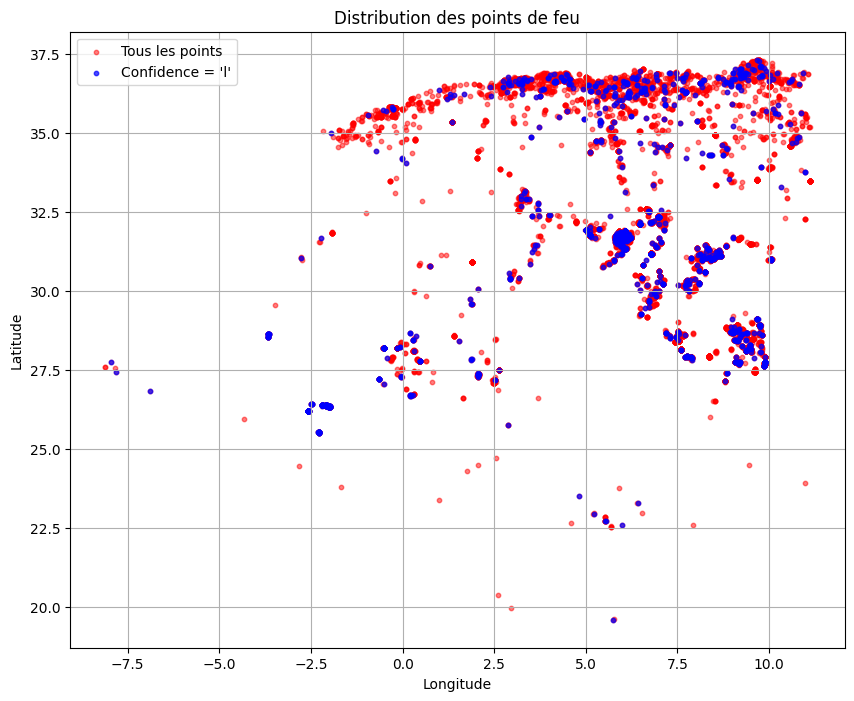

Nombre total de points : 14216
Nombre de points avec confidence = 'l' : 1292


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/content/drive/MyDrive/data_set/fire/fire_vege.csv")

df_low = df[df['confidence'] == 'l']

plt.figure(figsize=(10, 8))
plt.scatter(df['longitude'], df['latitude'], s=10, color='red', alpha=0.5, label='Tous les points')
plt.scatter(df_low['longitude'], df_low['latitude'], s=10, color='blue', alpha=0.7, label="Confidence = 'l'")

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Distribution des points de feu')
plt.legend()
plt.grid(True)
plt.show()

print("Nombre total de points :", len(df))
print("Nombre de points avec confidence = 'l' :", len(df_low))


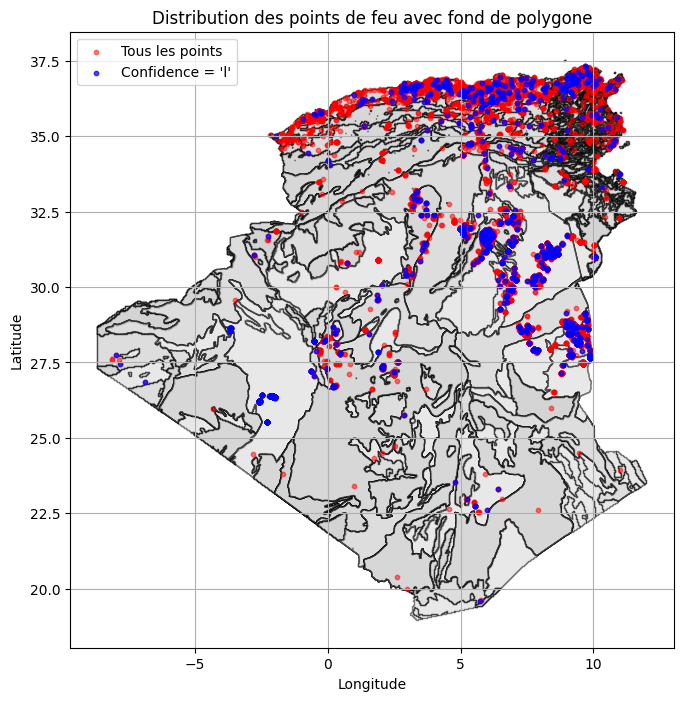

Nombre total de points : 14216
Nombre de points avec confidence = 'l' : 1292


In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# === Charger les données CSV ===
df = pd.read_csv("/content/drive/MyDrive/data_set/fire/fire_vege.csv")

# === Filtrer les points de faible confiance ===
df_low = df[df['confidence'] == 'l']

# === Charger le shapefile (couche de polygone) ===
# Remplace le chemin ci-dessous par le tien :
shapefile_path = "/content/drive/MyDrive/data_set/soil_type/shapefiles/joined attributes/HWSD_Algeria_Tunisia_joined.shp"
gdf_poly = gpd.read_file(shapefile_path)

# === Créer la figure ===
fig, ax = plt.subplots(figsize=(10, 8))

# === Afficher la couche de polygones (en dessous) ===
gdf_poly.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)

# === Superposer les points de feu ===
ax.scatter(df['longitude'], df['latitude'], s=10, color='red', alpha=0.5, label='Tous les points')
ax.scatter(df_low['longitude'], df_low['latitude'], s=10, color='blue', alpha=0.7, label="Confidence = 'l'")

# === Ajouter titres et légende ===
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Distribution des points de feu avec fond de polygone')
ax.legend()
ax.grid(True)

plt.show()

# === Informations sur les données ===
print("Nombre total de points :", len(df))
print("Nombre de points avec confidence = 'l' :", len(df_low))


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#Climat

missing values

In [ ]:
import os
import glob
import numpy as np
import rasterio
from rasterio import features
from shapely.geometry import shape, mapping
import geopandas as gpd

shapefile_path = "/content/drive/MyDrive/data_set/climate/algeria_tunisia_climate/climate_dzd_tun_polyg.shp"
gdf = gpd.read_file(shapefile_path)
missing_counts = gdf.isna().sum()

print("📊 Valeurs manquantes par colonne :")
print(missing_counts)

rows_with_missing = gdf[gdf.isna().any(axis=1)]
print(f"🔎 Nombre de lignes avec des valeurs manquantes : {len(rows_with_missing)}")
display(rows_with_missing.head())


📊 Valeurs manquantes par colonne :
month         0
tmin          1
tmax          1
precipitat    1
geometry      0
dtype: int64
🔎 Nombre de lignes avec des valeurs manquantes : 1


,month,tmin,tmax,precipitat,geometry
54383,9,NaN,NaN,NaN,"POLYGON ((10.5 36.75, 10.58333 36.75, 10.58333..."


In [ ]:
import geopandas as gpd
from libpysal.weights import Queen
import numpy as np
import pandas as pd

# === Charger le shapefile ===
gdf = gpd.read_file("/content/drive/MyDrive/data_set/climate/algeria_tunisia_climate/climate_dzd_tun_polyg.shp")

# === Colonnes attributs (tout sauf la géométrie) ===
colonnes_attributs = gdf.columns.drop('geometry','month')

# === Détecter les lignes avec tous les attributs nulls ===
lignes_tout_null =  gdf[gdf.isna().any(axis=1)]
print("Nombre de lignes à traiter :", len(lignes_tout_null))

# === Créer la matrice de voisinage Queen ===
w = Queen.from_dataframe(gdf)

# === Traiter chaque ligne avec tous les attributs nuls ===
for idx in lignes_tout_null.index:
    voisins_index = w.neighbors.get(idx, [])

    if voisins_index:
        for col in colonnes_attributs:
            # Moyenne des voisins pour cet attribut, en ignorant les NaN
            valeurs_voisins = gdf.loc[voisins_index, col].dropna()
            if not valeurs_voisins.empty:
                moyenne = valeurs_voisins.mean()
                gdf.at[idx, col] = moyenne
            else:
                # Si tous les voisins ont NaN, mettre 0 ou autre valeur par défaut
                gdf.at[idx, col] = 0
    else:
        # Si pas de voisins, mettre 0 ou autre valeur par défaut
        for col in colonnes_attributs:
            gdf.at[idx, col] = 0

print("Traitement terminé.")
# === (Optionnel) Sauvegarder le shapefile nettoyé ===
# gdf.to_file("chemin/vers/fichier_clean.shp")


Nombre de lignes à traiter : 1


/tmp/ipython-input-2007325520.py:17: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf)


Traitement terminé.


/usr/local/lib/python3.12/dist-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)
/tmp/ipython-input-2007325520.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6.622093023255814' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  gdf.at[idx, col] = moyenne


In [ ]:
rows_with_missing = gdf[gdf.isna().any(axis=1)]
print(f"🔎 Nombre de lignes avec des valeurs manquantes : {len(rows_with_missing)}")
display(rows_with_missing.head())

🔎 Nombre de lignes avec des valeurs manquantes : 0


,month,tmin,tmax,precipitat,geometry


In [ ]:
gdf.to_file("/content/drive/MyDrive/data_set/climate/climat_clean/climat_clean.shp")

/tmp/ipython-input-762238208.py:36: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/tmp/ipython-input-762238208.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


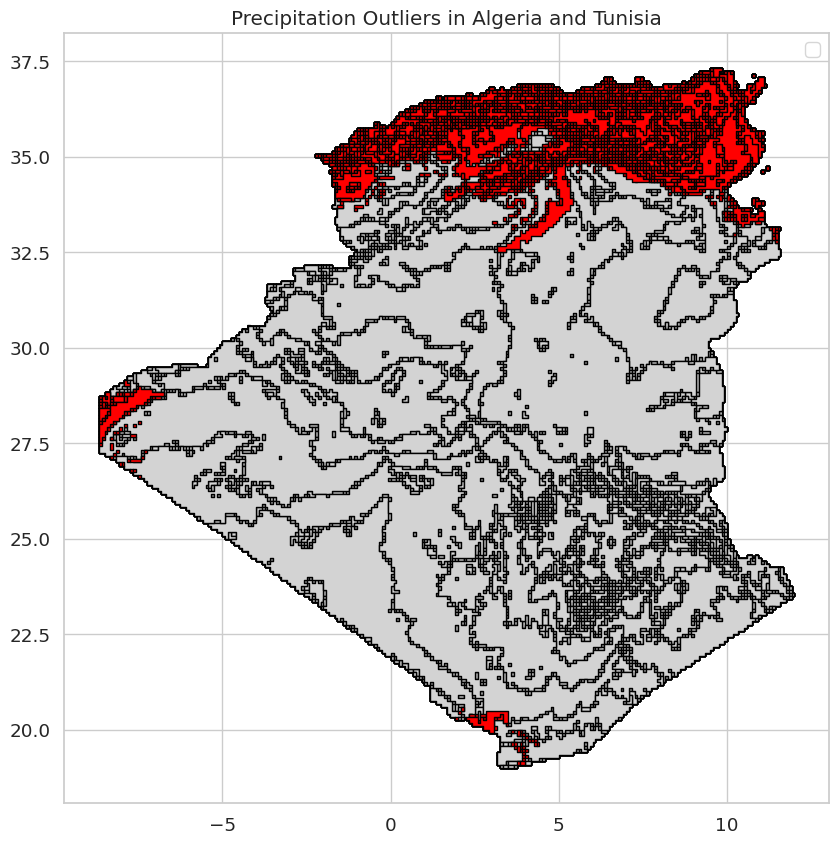

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os

# --- Load shapefile ---
root_folder = "/content/drive/MyDrive/data_set/climate/algeria_tunisia_climate"
shp_file = os.path.join(root_folder, "climate_dzd_tun_polyg.shp")
gdf = gpd.read_file(shp_file)

# --- Variable to check ---
var = "precipitat"
data = gdf[var].dropna()

# --- Compute IQR for outliers ---
q1 = np.percentile(data, 25)
q3 = np.percentile(data, 75)
iqr = q3 - q1
lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr

# --- Identify outlier polygons ---
outlier_mask = (gdf[var] < lower_bound) | (gdf[var] > upper_bound)
outliers_gdf = gdf[outlier_mask]

# --- Plot map ---
fig, ax = plt.subplots(figsize=(10,10))

# Plot all polygons in light gray
gdf.plot(ax=ax, color='lightgray', edgecolor='black')

# Overlay precipitation outliers in red
outliers_gdf.plot(ax=ax, color='red', edgecolor='black', label='Outliers')

plt.title("Precipitation Outliers in Algeria and Tunisia")
plt.legend()
plt.show()



# Pour les valeurs aberrantes de précipitation
# comme l’illustre la plupart des cas situés dans le nord
# et étant donné que le désert est plus étendu
# une faible quantité de précipitation devient un outlier.


In [ ]:
import geopandas as gpd

# Load the shapefile
shapefile_path = "/content/drive/MyDrive/data_set/soil_type/shapefiles/clean/cleaned_soil.shp"
gdf = gpd.read_file(shapefile_path)

# Number of polygons
num_polygons = len(gdf)
print("Number of polygons:", num_polygons)


Number of polygons: 5254


In [ ]:
num_unique_polygons = gdf['geometry'].drop_duplicates().shape[0]
print("Number of unique polygons:", num_unique_polygons)


Number of unique polygons: 3104


In [ ]:
import geopandas as gpd

# Load shapefile
shapefile_path = "/content/drive/MyDrive/data_set/soil_type/shapefiles/clean/cleaned_soil.shp"
gdf = gpd.read_file(shapefile_path)

# Convert geometries to WKT for comparison
geom_wkt = gdf['geometry'].apply(lambda x: x.wkt)

# Count occurrences of each unique polygon
geom_counts = geom_wkt.value_counts()

# Maximum number of times a polygon is repeated
max_repeats = geom_counts.max()
print("The maximum number of repetitions for a polygon is:", max_repeats)

# Optionally, see which polygon(s) is repeated the most
most_repeated = geom_counts[geom_counts == max_repeats]
print("Most repeated polygon(s):")
print(most_repeated)


The maximum number of repetitions for a polygon is: 7
Most repeated polygon(s):
geometry
POLYGON ((8.616666666666934 36.86666666666665, 8.625000000000266 36.86666666666665, 8.625000000000266 36.85833333333332, 8.650000000000265 36.85833333333332, 8.650000000000265 36.84999999999998, 8.66666666666693 36.84999999999998, 8.66666666666693 36.84166666666665, 8.675000000000264 36.84166666666665, 8.675000000000264 36.82499999999998, 8.66666666666693 36.82499999999998, 8.66666666666693 36.81666666666665, 8.641666666666932 36.81666666666665, 8.641666666666932 36.808333333333316, 8.625000000000266 36.808333333333316, 8.625000000000266 36.79999999999998, 8.591666666666931 36.79999999999998, 8.591666666666931 36.79166666666665, 8.583333333333599 36.79166666666665, 8.583333333333599 36.78333333333332, 8.550000000000267 36.78333333333332, 8.550000000000267 36.79166666666665, 8.54166666666693 36.79166666666665, 8.54166666666693 36.81666666666665, 8.5583333333336 36.81666666666665, 8.5583333333336 36.